In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import butter, hilbert, filtfilt, freqz, coherence
from scipy import stats
import random
import sys
sys.path.append('/Volumes/kaylab/Code.Repository/Python/') # where OpenEphys is stored

import OpenEphys


sf = 30000

ddir = '/Volumes/kaylab/DataStores/Data/BO/SiProbe/' # data directory


############### Define Functions ##################

def load_spikes_from_kwik(dfile, clust_choice, use_clust_choice):
    '''
    Inputs : dfile        - file directory (including filename)
             clust_choice - list of cluster labels you want to extract
             use_clust_choice - if 1 t
        
    Outputs: SPK          - list of spike times (in samples) for each cluster
    '''
    import h5py
    with h5py.File(dfile,'r') as D:
        # for viewing contents of folders
        # dv=D['/channel_groups/0/spikes/time_samples']
        # for i in iter(dv):
            # print(i)
        time_samples = D.get('/channel_groups/0/spikes/time_samples')
        np_time_samples = np.array(time_samples)
        cluster_labels = D.get('/channel_groups/0/spikes/clusters/main')
        np_cluster_labels = np.array(cluster_labels) # label of each individual spike
        cluster_names = D.get('/channel_groups/0/clusters/main')
        np_cluster_names = np.array(cluster_names) # name of each cluster category
        # must additionally convert from <U2 to int32
        np_cluster_names = np_cluster_names.astype('int32')
        
    SPK = []
    if use_clust_choice == 1:
        for i in range(len(clust_choice)):
            temp_ind = np.squeeze(np.array(np.where(np_cluster_labels == clust_choice[i])))
            SPK.append(np_time_samples[temp_ind])
    else:
        for i in range(len(np_cluster_names)):
            temp_ind = np.squeeze(np.array(np.where(np_cluster_labels == np_cluster_names[i])))
            SPK.append(np_time_samples[temp_ind])
    return SPK, np_cluster_names

def get_FR(spikes,bw,sf,maxt):
    # spikes     -     vector of spike times
    # bw         -     bin window (s)
    # sf         -     sampling fq
    # maxt       -     max time bin
    bins = np.arange(0,maxt,bw)
    [fr,bleh] = np.histogram(spikes/sf,bins)
    fr = fr/bw # convert counts to rate
    return fr

def butter_env(order, low, high, signal):
    b, a = butter(order, [low, high], btype='bandpass')
    filt_signal = filtfilt(b, a, signal)
    # Amplitude of analytic signal is the envelope
    hilb_filt_signal = hilbert(filt_signal)
    filt_signal_env = np.abs(hilb_filt_signal)
    # The instantaneous phase corresponds to the phase angle of the analytic signal
    filt_signal_ph = np.angle(hilb_filt_signal)
    return filt_signal, filt_signal_env, filt_signal_ph

def spike_field_prod_with_rand(spikes,field):
    # This function indexes field by spikes AND by a random array the same length as spikes
    # NOTE: this function assumes that spikes are sampled 10x higher than field
    # spike sample times must be subsampled and rounded to index ssLFP envelope
    ssinds = np.rint(0.1*np.array(spikes)) # round to nearest integer
    ssinds = ssinds.astype(int) # convert type to int
    SFprod = field[ssinds]
    # Do the same for randomly generated spikes as a control
    randinds = field.size*np.random.sample(spikes.size)
    randinds = randinds.astype(int) # convert type to int
    RFprod = field[randinds]
    return SFprod, RFprod

def spike_field_coh(spike_times,field,sssf):
 # This function uses the scipy.signal.coherence function. Must be imported
 # Assuming spike times are given in units of samples.
 # Also assuming LFP is subsampled by 10
 # This function bins spike times in bins of LFP sampling time, then computes coherence
    from scipy.signal import coherence
    bw = 10
    bins = np.arange(0,10*len(field),bw)
    [binned_spikes,bleh] = np.histogram(spike_times,bins)
    if len(binned_spikes) < len(field): # ensure binned spikes and LFP are same len
        binned_spikes=np.append(binned_spikes,0) # add zero to end
    elif len(binned_spikes) > len(field):
        binned_spikes=np.delete(binned_spikes,0) # delete 1st element
    f, Cxy = coherence(binned_spikes, field, sssf, nperseg=2000)
    # higher nperseg --> finer fq resolution
    return f, Cxy


# List folders on which to perform analysis
'''dfold_list = ['RK90_2016-09-29_raw_30k_30pres_EMB_awake',
             'RK90_2016-09-29_raw_30k_30pres_EMB_anesth'] # with odor TTL pulses'''

'''dfold_list = ['RK90_2016-07-29_raw_30k_1min_Acetone','RK90_2016-07-29_raw_30k_1min_EMB',
             'RK90_2016-07-29_raw_30k_1min_Ger','RK90_2016-07-29_raw_30k_1min_Hexanone',
              'RK90_2016-07-29_raw_30k_1min_MethylAcetate','RK90_2016-07-29_raw_30k_1min_PP',
             'RK90_2016-07-29_raw_30k_1min_S-Lim',
             'RK90_2016-08-15_raw_30k_1min_Acetone','RK90_2016-08-15_raw_30k_1min_EMB',
             'RK90_2016-08-15_raw_30k_1min_Ger','RK90_2016-08-15_raw_30k_1min_Hexanone',
              'RK90_2016-08-15_raw_30k_1min_MethylAcetate','RK90_2016-08-15_raw_30k_1min_PP',
             'RK90_2016-08-15_raw_30k_1min_S-Lim'] # no odor TTL pulses'''

dfold_list = ['RK90_2016-09-29_raw_30k_30pres_EMB_awake',
             'RK90_2016-09-11_raw_30k_30pres_EMB'] # with odor TTL pulses

In [2]:
################ MAIN LOOP ###################

sssf = 3000 # subsampled frequency of LFP

# Initialize Variables
# Theta
SFCth_max_LIST = []
SFCth_rand_max_LIST = []

# Beta
SFCb_max_LIST = []
SFCb_rand_max_LIST = []

# Low/High Gamma
SFClg_max_LIST = []
SFClg_rand_max_LIST = []
SFChg_max_LIST = []
SFChg_rand_max_LIST = []


for dd in range(len(dfold_list)):

    # choose data folder where files are stored
    dfold = dfold_list[dd]

    # number of odor presentations
    if dfold == 'RK90_2016-09-11_raw_30k_30pres_EMB':
        nop = 27 # accidentaly only got 27 trials on this one data set
    else:
        nop = 30
    # save figures?
    sflag = 0;

    #--------------- load LFP data -----------------#
    filepath = ddir + dfold + '/' + dfold + '_LFP.dat'
    ssLFP = np.fromfile(filepath, dtype='float') #subsampled LFP
    # NOTE!!! Downsampling not only saves space, but is also necessary to construct filters that 
    # operate in the beta range

    #--------------- Load events, extract odor periods ------------------#
    eventsname = 'all_channels.events'
    filepath = ddir + dfold + '/' + eventsname
    Events = OpenEphys.loadEvents(filepath)
    odor_periods = Events['timestamps']-Events['timestamps'][0]
    odor_periods = odor_periods[2:]
    # For some odd reason the TTL pulses will sometimes duplicate a few miliseconds after eachother
    # Smooth over the duplicates by binning time in 0.3s bins
    dl = 10*np.squeeze(ssLFP.shape) # data length
    a,b = np.histogram(odor_periods,np.arange(0,dl,0.3*sf))
    b = b[1:] # The first edge is 0 so we skip it
    odor_periods = b[a>0] # index where bin count is > 1
    # For some reason the last TTL OFF is not saved, so I add one 3s after the last ON
    odor_periods = np.hstack((odor_periods,odor_periods[-1]+3*sf))


    #----------- load spike times of each cluster for both shanks ------------#
    dfile1 = ddir + dfold + '/2017/shank1CMR/' + dfold + '_shank1CMR' + '.kwik'
    [SPK1,clust_names1] = load_spikes_from_kwik(dfile1, [], 0)

    dfile2 = ddir + dfold + '/2017/shank2CMR/' + dfold + '_shank2CMR' + '.kwik'
    [SPK2,clust_names2] = load_spikes_from_kwik(dfile2, [], 0)

    # remove clusters with <=10 spikes
    n=np.array([SPK1[i].size for i in range(len(SPK1))])
    m=np.where(n<=10)
    m=sorted(m[0],reverse=True)
    for i in m:
        del SPK1[i];
    n=np.array([SPK2[i].size for i in range(len(SPK2))])
    m=np.where(n<=10)
    m=sorted(m[0],reverse=True)
    for i in m:
        del SPK2[i];

    SPK = SPK1+SPK2
    nc1 = len(SPK1)
    nc2 = len(SPK2)
    # Spike times from both are saved in a single list SPK!

    #------------- Extract LFP and spikes in odor periods --------------#
    start = odor_periods[0::2] - sf # add 1s to each end of odor period
    stop = odor_periods[1::2] + sf

    ssLFP_op = list()
    SPK_op = list()
    op_num_spk = np.zeros(len(SPK)) # This will store number of real spikes during odor
    op_num_spk_randm = np.zeros(len(SPK)) # this will store mean number of rand gen spikes during odor
    op_num_spk_randstd = np.zeros(len(SPK)) # this will store mean number of rand gen spikes during odor

    for i in range(nop):
        # remember, LFP is subsampled by 10
        ssLFP_op.append(ssLFP[start[i]/10:stop[i]/10])
        SPKtmp = list()
        op_num_spk_temp = np.zeros(len(SPK))
        op_num_spk_randm_temp = np.zeros(len(SPK))
        op_num_spk_randstd_temp = np.zeros(len(SPK))
        for s in range(len(SPK)):
            # find spk times in odor periods. Don't save spikes within 10 smaples of the stop
            # to avoid later indexing issues when indexing last element of subsampled array
            sind = np.array(np.where((SPK[s] > start[i]) & (SPK[s] < (stop[i]-10))))
            sind = sind.astype(int) # convert type to int
            SPKtmp.append(SPK[s][sind]-start[i]) # subtract away start time of odor period
            op_num_spk_temp[s] = sind.size
            # fake spikes
            nst = len(SPK[s]) # number spikes tot (in given spiketrain)
            nsim=50 # number of random simulations
            store_sims = np.zeros(nsim)
            for srand in range(nsim):
                rand_spikes = np.floor(dl*np.random.random(nst)).astype(int) # gen rand spikes
                sind_rand = np.array(np.where((rand_spikes > start[i]) & (rand_spikes < (stop[i]-10))))
                sind_rand = sind_rand.astype(int) # convert type to int
                store_sims[srand] = sind_rand.size
            op_num_spk_randm_temp[s] = np.mean(store_sims) # simulation mean
            op_num_spk_randstd_temp[s] = np.std(store_sims) # simulation std
        SPK_op.append(SPKtmp)
        op_num_spk = op_num_spk+op_num_spk_temp # total # of spikes in odor periods
        op_num_spk_randm = op_num_spk_randm+op_num_spk_randm_temp
        op_num_spk_randstd = op_num_spk_randstd+op_num_spk_randstd_temp
    

    #--------------- Filter entire session for each frequency band -------------------#

    # Theta filtered LFP envelope with Butterworth filter
    #========================================================#
    nyq = 0.5 * sssf
    low = 1 / nyq
    high = 13 / nyq
    order = 3
    LFPth, LFPth_env, LFPth_ph = butter_env(order, low, high, ssLFP)


    # Beta filtered LFP envelope with Butterworth filter
    #========================================================#
    #nyq = 0.5 * sssf
    #low = 10 / nyq # it turns out that lowcut must be <15Hz to capture the large beta amplitude
    #high = 33 / nyq
    #order = 4
    #LFPb, LFPb_env, LFPb_ph = butter_env(order, low, high, ssLFP)


    # low gamma filtered LFP envelope with Butterworth filter
    #========================================================#
    nyq = 0.5 * sssf
    low = 35 / nyq
    high = 65 / nyq
    order = 5
    LFPlg, LFPlg_env, LFPlg_ph = butter_env(order, low, high, ssLFP)



    # high gamma filtered LFP envelope with Butterworth filter
    #========================================================#
    nyq = 0.5 * sssf
    low = 60 / nyq
    high = 100 / nyq
    order = 5
    LFPhg, LFPhg_env, LFPhg_ph = butter_env(order, low, high, ssLFP)


    #--------------- Spike-Theta SFC -------------------#

    LFPth_ph_1st70s = LFPth_ph[0:60*sssf] # 1min of baseline (ignore the 70s in the name)
    #LFPth_ph_1st70s = LFPth_ph[180*sssf:]

    SPHprodth = list() # SPHprodth will have length = len(SPK)
    RPHprodth = list()
    SPK_1st70s = list()
    SFCth = []
    SFCth_max = []
    SFCth_rand = []
    SFCth_rand_max = []
    for i in range(len(SPK)):
        ind_temp = np.array(np.where(SPK[i] < 60*sf))
        #SPK_1st70s.append(SPK[i][ind_temp]-180*sf)
        SPK_1st70s.append(SPK[i][ind_temp])
        SFprod, RFprod = spike_field_prod_with_rand(SPK_1st70s[i][0],LFPth_ph_1st70s)
        SPHprodth.append(SFprod)
        RPHprodth.append(RFprod)
        f, Cxy = spike_field_coh(SPK_1st70s[i][0],LFPth_ph_1st70s,sssf)
        SFCth.append(Cxy)
        randSPK = 10*len(LFPth_ph_1st70s)*np.random.random(SPK_1st70s[i].size)
        f, Cxy = spike_field_coh(randSPK,LFPth_ph_1st70s,sssf)
        SFCth_rand.append(Cxy)
        if len(SPK_1st70s[i][0]) > 40: #SFC is meaningless with too few spikes. 40 seems like good cutoff
            SFCth_max.append(np.max(SFCth[i][0:20]))
            SFCth_rand_max.append(np.max(SFCth_rand[i][0:20]))
        else:
            SFCth_max.append(np.nan)
            SFCth_rand_max.append(np.nan)
        


    #--------------- Spike-Beta SFC durind odor ---------------#
    # Filter odor periods only for beta
    nyq = 0.5 * sssf
    low = 10 / nyq # it turns out that lowcut must be <15Hz to capture the large beta amplitude
    high = 33 / nyq
    order = 4

    LFPb_op = list()
    LFPb_env_op = list()
    LFPb_ph_op = list()
    for i in range(nop):
        LFPbtemp, LFPb_envtemp, LFPb_phtemp = butter_env(order, low, high, ssLFP_op[i])
        LFPb_op.append(LFPbtemp)
        LFPb_envtemp[0:50] = 0 # Get rid of edge effects by setting envelope on either edge = 0!!!
        LFPb_envtemp[-50:] = 0 # This will also allow detection of suprathresh at start of window!
        LFPb_env_op.append(LFPb_envtemp)
        LFPb_ph_op.append(LFPb_phtemp)


    # spike-LFP phase histograms are calculated as well

    # These must only be calculated for regions where beta power is greater than some threshold
    thb = 0.25*max(np.hstack(LFPb_env_op)) # threshold
    startb_op = list()
    stopb_op = list()
    for i in range(nop):
        yo = LFPb_env_op[i] >= thb
        yo = yo.astype(float) # convert boolean to float
        yo = np.diff(yo)
        startb_op.append(10*np.squeeze(np.array(np.where(yo == 1)))) # multiply by 10 becaise LFP is subsampled
        stopb_op.append(10*np.squeeze(np.array(np.where(yo == -1)))) # multiply by 10 becaise LFP is subsampled
        if stopb_op[i].size == startb_op[i].size+1:
            stopb_op[i] = np.delete(stopb_op[i],0) # start and stop must be same length and aligned!

    # calculate Spike-LFP phase product and SFC for thresholded regions
    SPHprod = list() # SPHprod will have length = len(SPK)
    RPHprod = list() # same as SPHprod but for random spikes
    LFPb_cat = np.empty(0) # initialize array which will concatenate all beta periods
    SPKb_cat = [None]*len(SPK)
    for s in range(len(SPK)):
        cumulative_time_shift = 0 # cumulative shift in time to concatenate spike times because each op starts from 0
        SPHprod_temp = list()
        RPHprod_temp = list()
        SPKb_cat[s] = np.empty(0)
        for i in range(nop):
            # extract spikes for each start/stop pair of the thresholded region
            for b in range(startb_op[i].size):
                if np.isscalar(startb_op[i]): # if scalar don't index by b (only one beta in this op)
                    current_start = startb_op[i] # only saving this to realign spikes for 1D cat
                    bool_array =(SPK_op[i][s] > startb_op[i]) & (SPK_op[i][s] < stopb_op[i])
                    if s == 0: # concatenate LFPb only for first s (since s is over spikes)
                        LFPb_cat = np.append(LFPb_cat,LFPb_op[i][startb_op[i]/10:stopb_op[i]/10])
                else:
                    current_start = startb_op[i][b] # only saving this to realign spikes for 1D cat
                    bool_array =(SPK_op[i][s] > startb_op[i][b]) & (SPK_op[i][s] < stopb_op[i][b])
                    if s == 0: # concatenate LFPb only for first s (since s is over spikes)
                        LFPb_cat = np.append(LFPb_cat,LFPb_op[i][startb_op[i][b]/10:stopb_op[i][b]/10])
                sind = np.array(np.where(np.squeeze(bool_array)))
                if sind.size > 0: # trouble dealing with empty arrays
                    #ssinds = np.rint(0.1*np.array(SPK_op[i][s][0][sind])) # round to nearest integer
                    #ssinds = ssinds.astype(int) # convert type to int
                    # concatenate spike-phase products
                    [SFprod,RFprod] = spike_field_prod_with_rand(SPK_op[i][s][0][sind],LFPb_ph_op[i])
                    SPHprod_temp.append(SFprod)
                    RPHprod_temp.append(RFprod)
                    # concatenate spike times into single vector (used for SFC)
                    SPKb_cat[s] = np.append(SPKb_cat[s],SPK_op[i][s][0][sind]+cumulative_time_shift-current_start)
                if np.isscalar(startb_op[i]): # update time_shift
                    cumulative_time_shift = cumulative_time_shift+stopb_op[i]-startb_op[i]
                else:
                    cumulative_time_shift = cumulative_time_shift+stopb_op[i][b]-startb_op[i][b]
                    # NOTE: must subtract 2 different start times! Current start, and past start!
        # save spike-phase products for each cluster
        if len(SPHprod_temp) == 0:
            # np.hstack is unable to deal with empty entries (stupid)
            SPHprod.append(np.empty( shape=(0, 0) )) # must add empty ARRAY (not LIST) for later processing
            RPHprod.append(np.empty( shape=(0, 0) )) # must add empty ARRAY (not LIST) for later processing
        else:
            SPHprod.append(np.hstack(SPHprod_temp))
            RPHprod.append(np.hstack(RPHprod_temp))


    # Compute SFC
    SFCb = []
    SFCb_max = []
    SFCb_rand = []
    SFCb_rand_max = []
    for i in range(len(SPK)):
        f, Cxy = spike_field_coh(SPKb_cat[i],LFPb_cat,sssf)
        SFCb.append(Cxy)
        randSPK = 10*len(LFPb_cat)*np.random.random(SPKb_cat[i].size)
        f, Cxy = spike_field_coh(randSPK,LFPb_cat,sssf)
        SFCb_rand.append(Cxy)
        if len(SPKb_cat[i]) > 40: #SFC is meaningless with too few spikes. 40 seems like good cutoff
            SFCb_max.append(np.max(SFCb[i][0:30]))
            SFCb_rand_max.append(np.max(SFCb_rand[i][0:30]))
        else:
            SFCb_max.append(np.nan)
            SFCb_rand_max.append(np.nan)


    #--------------- Spike-Low/High Gamma SFC ----------------#
    # obtain start and stop of low and high gamma periods above a threshold
    thlg = 0.25*max(LFPlg_env) # low gamma threshold
    thhg = 0.2*max(LFPhg_env) # high gamma threshold
    yolg = LFPlg_env >= thlg
    yohg = LFPhg_env >= thhg
    yolg = yolg.astype(float) # convert boolean to float
    yohg = yohg.astype(float) # convert boolean to float
    yolg = np.diff(yolg)
    yohg = np.diff(yohg)
    startlg = np.squeeze(np.array(np.where(yolg == 1)))
    stoplg = np.squeeze(np.array(np.where(yolg == -1)))
    stoplg = stoplg[stoplg != 0] # if LFP happends start with high power then first stop will be 0
    if len(stoplg) == len(startlg)+1:
        stoplg = np.delete(stoplg,0) # start and stop must be same length and aligned!
    starthg = np.squeeze(np.array(np.where(yohg == 1)))
    stophg = np.squeeze(np.array(np.where(yohg == -1)))
    stophg = stophg[stophg != 0] # if LFP happends start with high power, then first stop will be 0
    if len(stophg) == len(starthg)+1:
        stophg = np.delete(stophg,0) # start and stop must be same length and aligned!

    # Get spike-LFP phase products low/high gamma periods
    SPHprodlg = list() # SPHprodlg will have length = len(SPK)
    SPHprodhg = list()
    RPHprodlg = list() # SPHprodlg will have length = len(SPK)
    RPHprodhg = list()
    lg_tot_spk = np.zeros(len(SPK)) # also save tot number of spikes in lg/hg
    hg_tot_spk = np.zeros(len(SPK))
    LFPlg_cat = [] # initialize list which I will later convert to 1D array (np.append is suuuuper slow)
    SPKlg_cat = [None]*len(SPK)
    LFPhg_cat = [] # initialize list which I will later convert to 1D array (np.append is suuuuper slow)
    SPKhg_cat = [None]*len(SPK)
    for i in range(len(SPK)):
        # low gamma
        SPHprodlg_temp = list()
        RPHprodlg_temp = list()
        SPKlg_cat[i] = np.empty(0) # np.append is slow, but since there are few spikes per j it ok
        cumulative_time_shiftlg = 0 # cumulative shift in time to concatenate spike times
        for j in range(startlg.size):
            ind_temp = np.array(np.where((SPK[i] > 10*startlg[j]) & (SPK[i] < 10*stoplg[j]-10)))
            spk_temp = SPK[i][ind_temp] - 10*startlg[j]
            if i == 0:
                LFPlg_cat.append(LFPlg[startlg[j]:stoplg[j]]) # only cat LFP once
            [SFprod,RFprod] = spike_field_prod_with_rand(spk_temp,LFPlg_ph[startlg[j]:stoplg[j]])
            SPHprodlg_temp.append(SFprod)
            RPHprodlg_temp.append(RFprod)
            lg_tot_spk[i] = lg_tot_spk[i] + ind_temp.size
            SPKlg_cat[i] = np.append(SPKlg_cat[i],spk_temp+cumulative_time_shiftlg)
            cumulative_time_shiftlg = cumulative_time_shiftlg + stoplg[j]-startlg[j]
        # save spike-phase products for each cluster
        if len(SPHprodlg_temp) == 0:
            # np.hstack is unable to deal with empty entries (stupid)
            SPHprodlg.append(np.empty( shape=(0, 0) ))
            RPHprodlg.append(np.empty( shape=(0, 0) ))
            # must add empty ARRAY (not LIST) for later processing
        else:
            SPHprodlg.append(np.hstack(SPHprodlg_temp))
            RPHprodlg.append(np.hstack(RPHprodlg_temp))
        # high gamma
        SPHprodhg_temp = list()
        RPHprodhg_temp = list()
        SPKhg_cat[i] = np.empty(0)
        cumulative_time_shifthg = 0 # cumulative shift in time to concatenate spike times
        for j in range(starthg.size):
            ind_temp = np.array(np.where((SPK[i] > 10*starthg[j]) & (SPK[i] < 10*stophg[j]-10)))
            spk_temp = SPK[i][ind_temp] - 10*starthg[j]
            if i == 0:
                LFPhg_cat.append(LFPhg[starthg[j]:stophg[j]]) # only cat LFP once
            [SFprod,RFprod] = spike_field_prod_with_rand(spk_temp,LFPhg_ph[starthg[j]:stophg[j]])
            SPHprodhg_temp.append(SFprod)
            RPHprodhg_temp.append(RFprod)
            hg_tot_spk[i] = hg_tot_spk[i] + ind_temp.size
            SPKhg_cat[i] = np.append(SPKhg_cat[i],spk_temp+cumulative_time_shifthg)
            cumulative_time_shifthg = cumulative_time_shifthg + stophg[j]-starthg[j]
        # save spike-phase products for each cluster
        if len(SPHprodhg_temp) == 0:
            # np.hstack is unable to deal with empty entries (stupid)
            SPHprodhg.append(np.empty( shape=(0, 0) ))
            RPHprodhg.append(np.empty( shape=(0, 0) ))
            # must add empty ARRAY (not LIST) for later processing
        else:
            SPHprodhg.append(np.hstack(SPHprodhg_temp))
            RPHprodhg.append(np.hstack(RPHprodhg_temp))

    # Compute SFC
    # flatten list of arrays into 1D array
    LFPlg_cat = np.concatenate(LFPlg_cat).ravel()
    LFPhg_cat = np.concatenate(LFPhg_cat).ravel()
    SFClg = []
    SFClg_max = []
    SFClg_rand = []
    SFClg_rand_max = []
    SFChg = []
    SFChg_max = []
    SFChg_rand = []
    SFChg_rand_max = []
    for i in range(len(SPK)):
        #lg
        f, Cxy = spike_field_coh(SPKlg_cat[i],LFPlg_cat,sssf)
        SFClg.append(Cxy)
        SFClg_max.append(np.max(SFClg[i][0:60]))
        randSPK = 10*len(LFPlg_cat)*np.random.random(SPKlg_cat[i].size)
        f, Cxy = spike_field_coh(randSPK,LFPlg_cat,sssf)
        SFClg_rand.append(Cxy)
        if len(SPKlg_cat[i]) > 40: #SFC is meaningless with too few spikes. 40 seems like good cutoff
            SFClg_max.append(np.max(SFClg[i][1:60]))
            SFClg_rand_max.append(np.max(SFClg_rand[i][1:60]))
        else:
            SFClg_max.append(np.nan)
            SFClg_rand_max.append(np.nan)
        #hg
        f, Cxy = spike_field_coh(SPKhg_cat[i],LFPhg_cat,sssf)
        SFChg.append(Cxy)
        SFChg_max.append(np.max(SFChg[i][0:60]))
        randSPK = 10*len(LFPhg_cat)*np.random.random(SPKhg_cat[i].size)
        f, Cxy = spike_field_coh(randSPK,LFPhg_cat,sssf)
        SFChg_rand.append(Cxy)
        if len(SPKhg_cat[i]) > 40: #SFC is meaningless with too few spikes. 40 seems like good cutoff
            SFChg_max.append(np.max(SFChg[i][1:60]))
            SFChg_rand_max.append(np.max(SFChg_rand[i][1:60]))
        else:
            SFChg_max.append(np.nan)
            SFChg_rand_max.append(np.nan)


    #------------------- Store variables ------------------#

    # Theta
    SFCth_max_LIST.append(SFCth_max)
    SFCth_rand_max_LIST.append(SFCth_rand_max)

    # Beta
    SFCb_max_LIST.append(SFCb_max)
    SFCb_rand_max_LIST.append(SFCb_rand_max)

    # Low/High Gamma
    SFClg_max_LIST.append(SFClg_max)
    SFClg_rand_max_LIST.append(SFClg_rand_max)
    SFChg_max_LIST.append(SFChg_max)
    SFChg_rand_max_LIST.append(SFChg_rand_max)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:92: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:249: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:244: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/scipy/signal/spectral.py:622: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


loading events...
loading events...


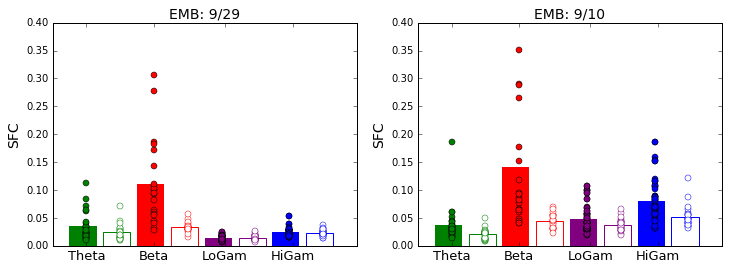

In [6]:
sflag = 1

#titles = ['Awake','Anesth']
titles = ['EMB: 9/29','EMB: 9/10']
plt.figure(figsize=(12,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    #th
    plt.bar(0.5,np.nanmean(SFCth_max_LIST[i]),edgecolor='none',color=[0,0.5,0])
    plt.plot(np.ones_like(SFCth_max_LIST[i]),SFCth_max_LIST[i],'o',color=[0,0.5,0])
    plt.bar(1.5,np.nanmean(SFCth_rand_max_LIST[i]),edgecolor=[0,0.5,0],color='w')
    plt.plot(2*np.ones_like(SFCth_rand_max_LIST[i]),SFCth_rand_max_LIST[i],'wo',markeredgecolor=[0,0.5,0])
    #b
    plt.bar(2.5,np.nanmean(SFCb_max_LIST[i]),edgecolor='none',color='r')
    plt.plot(3*np.ones_like(SFCb_max_LIST[i]),SFCb_max_LIST[i],'ro')
    plt.bar(3.5,np.nanmean(SFCb_rand_max_LIST[i]),edgecolor='r',color='w')
    plt.plot(4*np.ones_like(SFCb_rand_max_LIST[i]),SFCb_rand_max_LIST[i],'wo',markeredgecolor='r')
    #lg
    plt.bar(4.5,np.nanmean(SFClg_max_LIST[i]),edgecolor='none',color=[0.5,0,0.5])
    plt.plot(5*np.ones_like(SFClg_max_LIST[i]),SFClg_max_LIST[i],'o',color=[0.5,0,0.5])
    plt.bar(5.5,np.nanmean(SFClg_rand_max_LIST[i]),edgecolor=[0.5,0,0.5],color='w')
    plt.plot(6*np.ones_like(SFClg_rand_max_LIST[i]),SFClg_rand_max_LIST[i],'wo',markeredgecolor=[0.5,0,0.5])
    #hg
    plt.bar(6.5,np.nanmean(SFChg_max_LIST[i]),edgecolor='none',color='b')
    plt.plot(7*np.ones_like(SFChg_max_LIST[i]),SFChg_max_LIST[i],'bo')
    plt.bar(7.5,np.nanmean(SFChg_rand_max_LIST[i]),edgecolor='b',color='w')
    plt.plot(8*np.ones_like(SFChg_rand_max_LIST[i]),SFChg_rand_max_LIST[i],'wo',markeredgecolor='b')
    
    plt.title(titles[i],fontsize=14)
    plt.ylabel('SFC',fontsize=14),plt.ylim([0,0.4])
    labels = ['Theta', 'Beta', 'LoGam', 'HiGam']
    plt.xticks([1,3,5.1,7.1], labels,fontsize=13)

if sflag == 1:
    plt.savefig('figs/'+dfold+'_EMB3weeksapart.png', bbox_inches='tight')

In [ ]:
dfold_list